#### Initalise dataset and config object

In [9]:
from config_price_history_only import cfg
from dataset_loaders import TweetXPriceY

cfg.dataset_loader_args['day_lag'] = 10
cfg.dataset_loader_args['tweets_per_day'] = 2
cfg.dataset_loader_args['words_per_tweet'] = 20
cfg.rnn_hidden_layers = 3
cfg.LEARNING_RATE = 0.00005

train_data = TweetXPriceY(start_date=cfg.train_start_date, 
                          end_date=cfg.train_end_date, 
                          **cfg.dataset_loader_args
                          )

eval_data = TweetXPriceY(start_date=cfg.eval_start_date, 
                         end_date=cfg.eval_end_date, 
                         **cfg.dataset_loader_args
                         )



In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
eval_dataloader = DataLoader(eval_data, batch_size=32, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f'Length train set: {train_data.__len__()}, Length Eval set: {eval_data.__len__()}')
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(train_features[0])

Length train set: 34050, Length Eval set: 5307
Feature batch shape: torch.Size([32, 10, 2, 20])
Labels batch shape: torch.Size([32])
tensor([[[    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.],
         [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.]],

        [[    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.],
         [    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.]],

        [[    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,

## Create the model

In [11]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


class RNN_simple(nn.Module):
    def __init__(self) -> None:
        super(RNN_simple, self).__init__()
        #self.embedding = nn.Embedding(cfg.vocab_size, embedding_dim=50)
        self.rnn = nn.RNN(input_size=cfg.dataset_loader_args['tweets_per_day']*cfg.dataset_loader_args['words_per_tweet'], hidden_size=cfg.rnn_hidden_size, num_layers=cfg.rnn_hidden_layers, batch_first=True)
        self.fc = nn.Linear(cfg.rnn_hidden_size, 2)

        
    def forward(self, x):
        #x = self.embedding(x)
        h0 = torch.zeros(cfg.rnn_hidden_layers, x.size(0), cfg.rnn_hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]  # Use the output from the last time step
        out = self.fc(out)
        return out
    


class RNN_simple_v2(nn.Module):
    def __init__(self) -> None:
        super(RNN_simple, self).__init__()
        #self.embedding = nn.Embedding(cfg.vocab_size, embedding_dim=50)
        self.rnn = nn.RNN(input_size=cfg.dataset_loader_args['tweets_per_day']*cfg.dataset_loader_args['words_per_tweet'], hidden_size=cfg.rnn_hidden_size, num_layers=cfg.rnn_hidden_layers, batch_first=True)
        self.fc = nn.Linear(cfg.rnn_hidden_size, 2)

        
    def forward(self, x):
        #x = self.embedding(x)
        h0 = torch.zeros(cfg.rnn_hidden_layers, x.size(0), cfg.rnn_hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]  # Use the output from the last time step
        out = self.fc(out)
        return out
    



In [12]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


class LSTM_v1(nn.Module):
    def __init__(self) -> None:
        super(LSTM_v1, self).__init__()
        #self.embedding = nn.Embedding(cfg.vocab_size, embedding_dim=50)
        self.embedding = nn.Embedding(cfg.vocab_size, embedding_dim=128, padding_idx=0)
        #self.rnn = nn.LSTM(input_size=cfg.dataset_loader_args['tweets_per_day']*cfg.dataset_loader_args['words_per_tweet'], hidden_size=cfg.rnn_hidden_size, num_layers=cfg.rnn_hidden_layers, batch_first=True)
        self.lstm = nn.LSTM(
            input_size=128,  # Embedding dimension
            hidden_size=cfg.rnn_hidden_size, 
            num_layers=cfg.rnn_hidden_layers, 
            batch_first=True,
            dropout=0.3
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(cfg.rnn_hidden_size, 2)

        
    def forward(self, x):
        x = x.long()
        x = self.embedding(x)  # Shape: (batch_size, seq_length, embedding_dim)
        out, _ = self.lstm(x)  # Shape: (batch_size, seq_length, hidden_size)
        out = self.dropout(out[:, -1, :])  # Use the output from the last time step
        out = self.fc(out)  # Shape: (batch_size, 2)
        return out  # Raw logits

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def evaluate_model(dataloader, model):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    all_logits = []
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(tqdm(dataloader)):
            x, y = x.to(device), y.to(device)
            x = x.float()
            #x = x.view(x.size(0), x.size(1), -1)  # Ensure input shape is (batch_size, seq_length, input_size)
            x = x.view(x.size(0), -1)

            outputs = model(x)  # Outputs are raw logits of shape (batch_size, num_classes)
            _, predicted = torch.max(outputs.data, 1)

            

            total += y.size(0)
            correct += (predicted == y).sum().item()

            # Collect data for debugging
            all_logits.append(outputs.cpu())
            all_preds.append(predicted.cpu())
            all_targets.append(y.cpu())

    accuracy = correct / total

    print(f'Accuracy: {accuracy:.4f}%')

    # Concatenate all the collected and transform to numpy array
    y_hat_logits = torch.cat(all_logits).numpy()
    y_hat = torch.cat(all_preds).numpy()
    y = torch.cat(all_targets).numpy()

    return  accuracy, y, y_hat, y_hat_logits

### Train loop cell

In [14]:

from time import time

model = LSTM_v1()

criterion = cfg.loss_func()
optimizer = cfg.optimizer(model.parameters(), lr=cfg.LEARNING_RATE)

EPOCHS = cfg.EPOCHS
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

eval_accuracy_across_epochs = []
train_accuracy_across_epochs = []
loss_across_epochs = []
training_time = []

for epoch in range(EPOCHS):
    epoch_start_time = time()
    epoch_loss = 0
    total, correct = 0, 0
    model.train()

    for batch_idx, (x, y) in enumerate(tqdm(train_dataloader)):
        x, y = x.to(device), y.to(device)


        x = x.int()

        x = x.view(x.size(0), -1)  # (32, 5, 60)
        #print(x.shape)
        outputs = model(x).squeeze()
        #Extracting predictions to evaluate test set performance
        _, predicted = torch.max(outputs.data, 1)

        total += y.size(0)
        correct += (predicted == y).sum().item()

        loss = criterion(outputs, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

         # Print progress
        if (batch_idx + 1) % 100 == 0:
            #print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{batch_idx+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
            pass

    epoch_end_time = time()
    training_time.append(epoch_end_time-epoch_start_time)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Average Loss: {epoch_loss/len(train_dataloader):.4f}")

    average_epoch_loss = epoch_loss/len(train_dataloader)
    loss_across_epochs.append(average_epoch_loss)

    #Get accuracy for each epoch on train and eval set
    train_accuracy = correct/total
    eval_accuracy, _, _, _ = evaluate_model(eval_dataloader, model)
    model.train()

    train_accuracy_across_epochs.append(train_accuracy)
    eval_accuracy_across_epochs.append(eval_accuracy)

total_training_time = sum(training_time)
h, rem = divmod(total_training_time, 3600)
m, s = divmod(rem, 60)


log_object = {
    'Dataclass': type(train_data).__name__,
    'Model': type(model).__name__,
    'Report from Training': {
        'training_time': f'{h}h {m}m {s}s',
        'loss_across_epochs': loss_across_epochs,
        'eval_accuracy_per_epoch': eval_accuracy_across_epochs,
        'train_accuracy_per_epoch': train_accuracy_across_epochs
    }
}



100%|██████████| 1065/1065 [01:41<00:00, 10.51it/s]


Epoch [1/10], Average Loss: 0.6929


  0%|          | 0/166 [00:00<?, ?it/s]


ValueError: LSTM: Expected input to be 2D or 3D, got 4D instead

## Logging cell

In [ ]:
import os
import json
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score



accuracy_eval, y, y_hat, y_hat_logits = evaluate_model(eval_dataloader, model)
accuracy_train, _, _, _ = evaluate_model(train_dataloader, model)

F1 = f1_score(y, y_hat)
precision = precision_score(y, y_hat)
recall = recall_score(y, y_hat)

log_object['Results'] = {
    'accuracy_eval': accuracy_eval,
    'accuracy_train': accuracy_train,
    'F1_eval': F1,
    'precision_eval': precision,
    'recall_eval': recall,
    'y_eval': y.tolist(),
    'y_hat_eval': y_hat.tolist(),
    'y_hat_logits_eval': y_hat_logits.tolist()
}





100%|██████████| 166/166 [00:11<00:00, 14.17it/s]


Accuracy: 0.4863%


100%|██████████| 1065/1065 [01:17<00:00, 13.72it/s]

Accuracy: 0.5805%


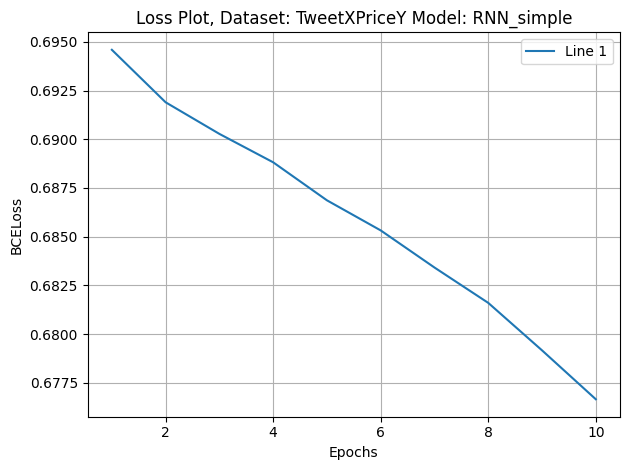

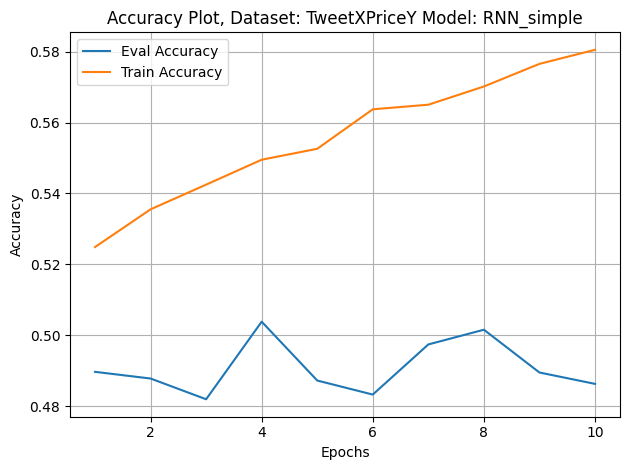

In [ ]:
def write_log_to_file(experiment_name:str, log_obj:dict):
    '''experiment_name is the name the file will be stored with. Suggested as f"model_{model_class}_dataset_{dataset_class}". The name gets "_{id}.json" appended'''
    root = 'results/'
    result_dir = os.path.join(root, experiment_name)

    if not result_dir.split('/')[-1] in os.listdir(root):
        os.makedirs(result_dir)

    #Create new id with 4 digits incrementally
    dir_ids = [int(path.split(".")[-2].split('_')[0]) for path in os.listdir(result_dir)]
    new_id = str(max(dir_ids)+ 1) if len(dir_ids) > 0 else '0'     #Increment max id by 1 or set to 0 if no id present
    id = '0'*(4-len(new_id)) + new_id    #Make id 4 digits

    target_file = os.path.join(result_dir, f'{id}.json')
    with open(target_file, 'w') as f:
        json.dump(log_obj, f, indent=4)
    
    return target_file

import inspect
def log_config(log_object, config):
    config_to_log = {}
    for key, value in vars(config).items():
        #print(key, inspect.isclass(value), inspect.isfunction(value))
        if inspect.isclass(value) or inspect.isfunction(value): #or isinstance(value, types.FunctionType):  # Check if it's a class instance
            config_to_log[key] = value.__name__  # Log the class name
            #print(config_to_log[key])
        elif isinstance(value, np.ndarray):
            config_to_log[key] = value.tolist()
        else:
            config_to_log[key] = value  # Log the value directly for primitive types
    log_object['Config'] = config_to_log
    #Rearrange dict so config comes after dataset and model
    log_object = {k: log_object[k] for k in list(log_object.keys())[:2] + ['Config'] + list(log_object.keys())[2:-1]}
    return log_object

cfg.optimizer = optim.Adam
cfg.loss_func = nn.BCELoss
log_object = log_config(log_object, cfg)

created_file_path = write_log_to_file(f"model_{type(model).__name__}_dataset_{type(train_data).__name__}", log_object)

from result_dataprocessing import generate_training_plot_from_file

generate_training_plot_from_file(created_file_path)

## Hyper Parameter Tuning